# Transcriptional trajectories in mouse limb buds reveal the transition from anterior-posterior to proximal-distal patterning at early limb bud stage.
Desanlis I, Paul R, Kmita M. J Dev Biol. 2020;8(4):1–16. 
 
 PMID: [7768367](http://www.ncbi.nlm.nih.gov/pmc/articles/pmc7768367/)
 ***
 

## 0. Setting up workenvironment<a id="0"></a>

In [2]:
suppressPackageStartupMessages({
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scuttle)
    library(Seurat)
    library(SeuratWrappers)
    library(stringr)
    library(dplyr)
    library(data.table)
    library(Matrix)
    library(patchwork)
    library(ggplot2)
})

options(repr.plot.width = 16, repr.plot.height = 8)

## 1. Importing data<a id="1"></a>


### 1.1. Seurat object<a id="2"></a>

#### 1.1.1. E10.5

In [2]:
E10_5.data <- Read10X(data.dir = "./6-kmita/fastq-files-kmita/SRR12748008/E10_5/outs/filtered_feature_bc_matrix/")
E10_5 <- CreateSeuratObject(counts = E10_5.data)
rm(E10_5.data)

#### 1.1.2. E11.5

In [3]:
E11_5.data <- Read10X(data.dir = "./6-kmita/fastq-files-kmita/SRR12748009/E11_5/outs/filtered_feature_bc_matrix/")
E11_5 <- CreateSeuratObject(counts = E11_5.data)
rm(E11_5.data)

#### 1.1.3. E12.5

In [4]:
E12_5.data <- Read10X(data.dir = "./6-kmita/fastq-files-kmita/SRR12748010/E12_5/outs/filtered_feature_bc_matrix/")
E12_5 <- CreateSeuratObject(counts = E12_5.data)
rm(E12_5.data)

In [5]:
E10_5
E11_5
E12_5

An object of class Seurat 
32285 features across 6440 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

An object of class Seurat 
32285 features across 6802 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

An object of class Seurat 
32285 features across 8730 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

### 1.2. Metadata<a id="3"></a>
#### 1.2.1. Series matrix file

GEO succesion number: [GSE158820](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158820)

In [ ]:
#dir.create('./6-kmita/metadata')

#url <- "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE158nnn/GSE158820/matrix/GSE158820_series_matrix.txt.gz"

#destfile <- "./6-kmita/metadata/GSE158820_series_matrix.txt.gz"

#download.file(url, destfile, method = "curl", quiet = FALSE)

In [6]:
lines <- readLines("./6-kmita/metadata/GSE158820_series_matrix.txt.gz")

# keep only sample data, drop series info
sampledata <- lines[which(grepl("!Sample", lines))]
write.table(sampledata, file = "./6-kmita/metadata/sampledata.txt", sep = "\t", quote = FALSE, row.names = FALSE, col.names = FALSE) #save

# load and transpose
sampledata <- as.data.frame(t(fread("./6-kmita/metadata/sampledata.txt", sep = "\t")))

# set header
names(sampledata) <- as.matrix(sampledata[1, ])
sampledata <- sampledata[-1, ]
sampledata[] <- lapply(sampledata, function(x) type.convert(as.character(x), as.is = FALSE))
rownames(sampledata) <- sampledata$`!Sample_geo_accession` # give samples a meaningful label that allows quick lookup if/when neeeded

#### 1.2.2. Metadata from SRA Run Selector
We manually download the metadata from the SRA Run Selector and match it to the series matrix file to combine all available metadata.

In [7]:
sraruntbl <- fread(file = "./6-kmita/metadata/SraRunTable.txt")

rownames(sraruntbl) <- sraruntbl$`GEO_Accession (exp)` # match rownames to series matrix file

In [8]:
metadata <- as.data.frame(cbind(sraruntbl, sampledata))

We then subset the columns that are of interest to us and add some additional info.

In [9]:
meta <- metadata[,c("Sample Name", "Instrument", "Organism", "Developmental_stage", 
                    "source_name", "STRAIN", "Tissue"),]
colnames(meta) <- c("Sample_Name", "Instrument", "Organism", "Developmental_stage", 
                    "source_name", "STRAIN", "Tissue")

meta$Technology <- "10x 3' v3.0.1"  #check this 

rownames(meta) <- meta$Sample_Name
head(meta)

,Sample_Name,Instrument,Organism,Developmental_stage,source_name,STRAIN,Tissue,Technology
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4811354,GSM4811354,Illumina NovaSeq 6000,Mus musculus,embryonic day E10.5,Forelimb bud,C57BL/6X129,Forelimb bud,10x 3' v3.0.1
GSM4811355,GSM4811355,Illumina NovaSeq 6000,Mus musculus,embryonic day E11.5,Forelimb bud,C57BL/6X129,Forelimb bud,10x 3' v3.0.1
GSM4811356,GSM4811356,Illumina NovaSeq 6000,Mus musculus,embryonic day E12.5,Forelimb bud,C57BL/6X129,Forelimb bud,10x 3' v3.0.1


In [10]:
meta_E10_5 <- (meta[1,] %>% slice(rep(1:n(), each = nrow(E10_5@meta.data))))
rownames(meta_E10_5) <- rownames(E10_5@meta.data)

E10_5 <- AddMetaData(E10_5, meta_E10_5)
rm(meta_E10_5)

In [11]:
meta_E11_5 <- (meta[2,] %>% slice(rep(1:n(), each = nrow(E11_5@meta.data))))
rownames(meta_E11_5) <- rownames(E11_5@meta.data)

E11_5 <- AddMetaData(E11_5, meta_E11_5)
rm(meta_E11_5)

In [12]:
meta_E12_5 <- (meta[3,] %>% slice(rep(1:n(), each = nrow(E12_5@meta.data))))
rownames(meta_E12_5) <- rownames(E12_5@meta.data)

E12_5 <- AddMetaData(E12_5, meta_E12_5)
rm(meta_E12_5)

## 2. Preprocessing: quality control with scater<a id="4"></a>

### 2.1. E10.5<a id="5"></a>

#### 2.1.1. Converting a Seurat object to SingleCellExperiment 

In [13]:
sce_E10_5 <- as.SingleCellExperiment(E10_5)

#### 2.1.2. Calculating QC metrics

In [17]:
is.mito <- grepl("^mt-", rownames(sce_E10_5))
mito.list <-  grep("^mt-", rownames(sce_E10_5), value = TRUE)

In [18]:
is.spike <- grepl("^gSpikein", rownames(sce_E10_5))
spike.list <- grep("^gSpikein", rownames(sce_E10_5), value = TRUE)

In [19]:
celldata <- perCellQCMetrics(sce_E10_5, subsets = list(Mt = is.mito, ERCC = is.spike))

In [21]:
sce_E10_5 <- addPerCellQC(sce_E10_5, subsets=list(Mito = is.mito, ERCC = is.spike))
colnames(colData(sce_E10_5))

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
 [4] "Sample_Name"           "Instrument"            "Organism"             
 [7] "Developmental_stage"   "source_name"           "STRAIN"               
[10] "Tissue"                "Technology"            "ident"                
[13] "sum"                   "detected"              "subsets_Mito_sum"     
[16] "subsets_Mito_detected" "subsets_Mito_percent"  "subsets_ERCC_sum"     
[19] "subsets_ERCC_detected" "subsets_ERCC_percent"  "total"                
[22] "sum"                   "detected"              "subsets_Mito_sum"     
[25] "subsets_Mito_detected" "subsets_Mito_percent"  "subsets_ERCC_sum"     
[28] "subsets_ERCC_detected" "subsets_ERCC_percent"  "total"

Expression of all ERCC spikeins is 0 because they were not used in this study.

##### **2.1.2.1. QC of the cells by feature number and library size**
Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the **total sum of counts across all features, i.e. genes.** Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as **the number of features with non-zero counts for that cell.** Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. **We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median** (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.

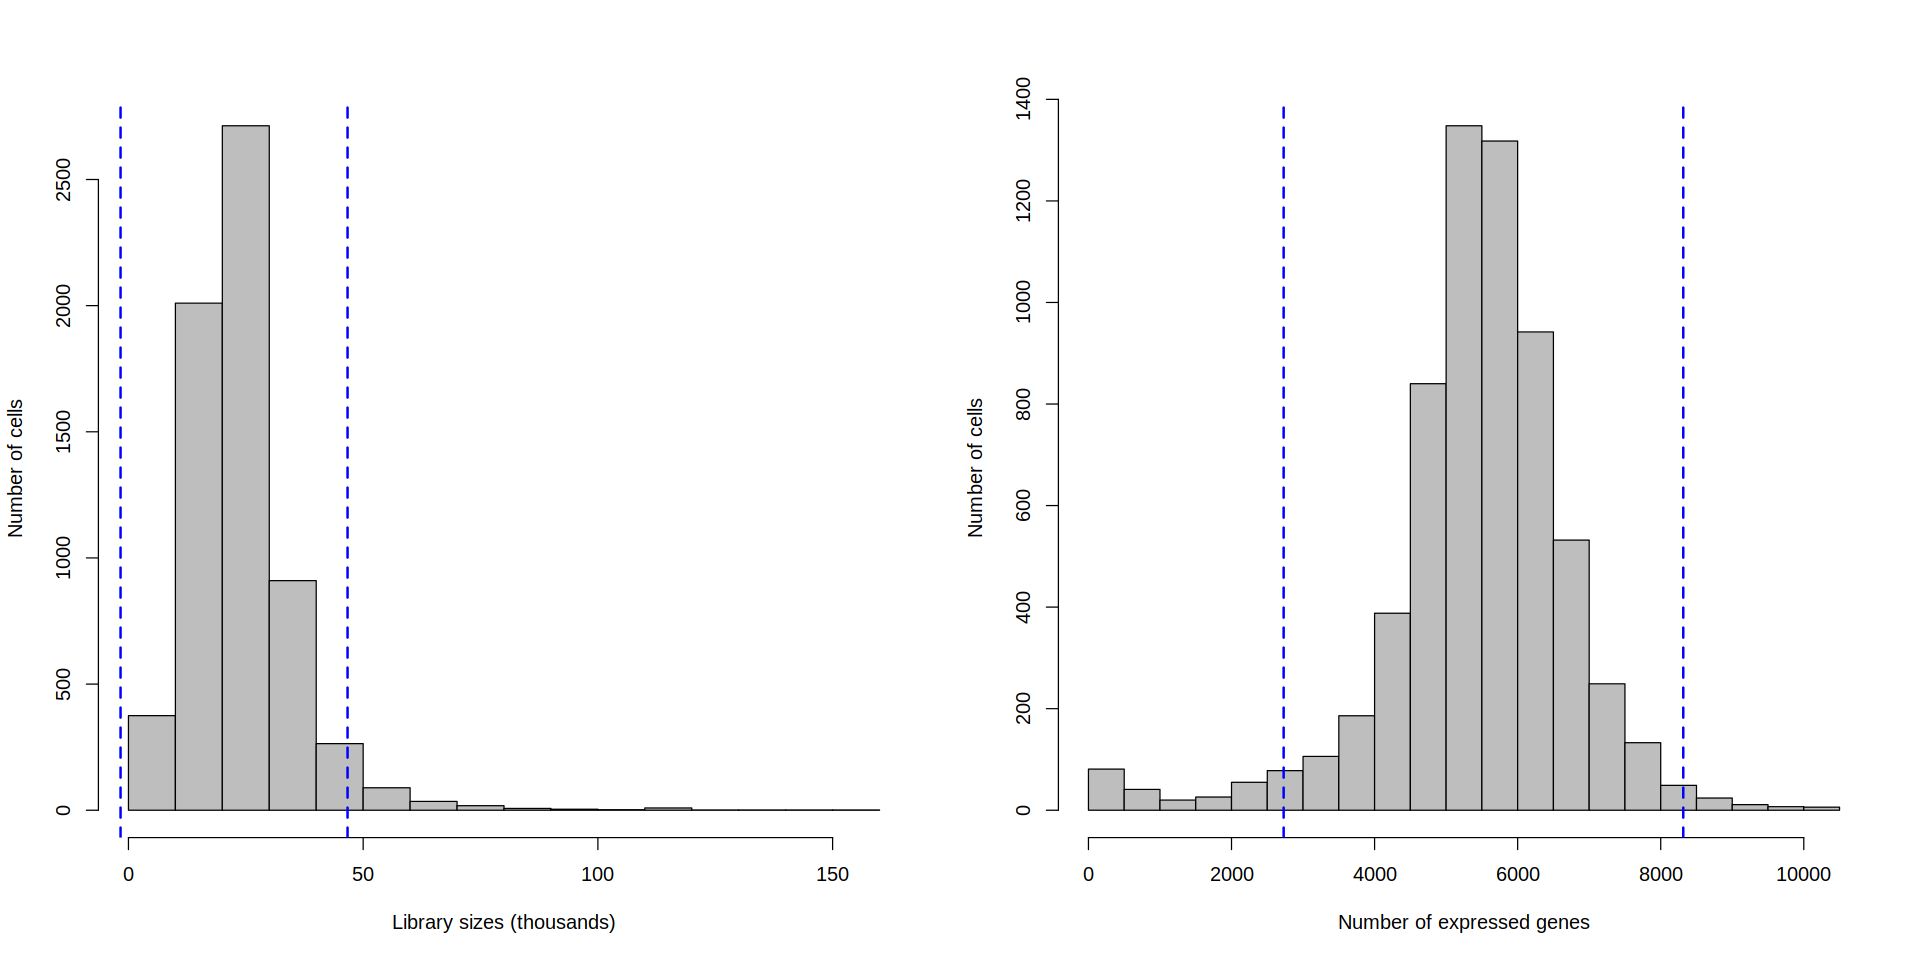

In [23]:
libsize.drop <- isOutlier(sce_E10_5$sum, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sce_E10_5$detected, nmads = 3, type = "both", log = TRUE)

# libsize.drop cutoff values
min.libsize <- (median(sce_E10_5$sum) - 3*mad(sce_E10_5$sum))/1e3
max.libsize <- (median(sce_E10_5$sum) + 3*mad(sce_E10_5$sum))/1e3

# feature.drop cutoff values
min.features <- (median(sce_E10_5$detected) - 3*mad(sce_E10_5$detected))
max.features <- (median(sce_E10_5$detected) + 3*mad(sce_E10_5$detected))

par(mfrow = c(1,2))

hist(sce_E10_5$sum/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.libsize, col = "blue", lwd = 2, lty = 2)
abline(v = max.libsize, col = "blue", lwd = 2, lty = 2)

hist(sce_E10_5$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

##### **2.1.2.2. Proportion of mitochondrial reads**

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

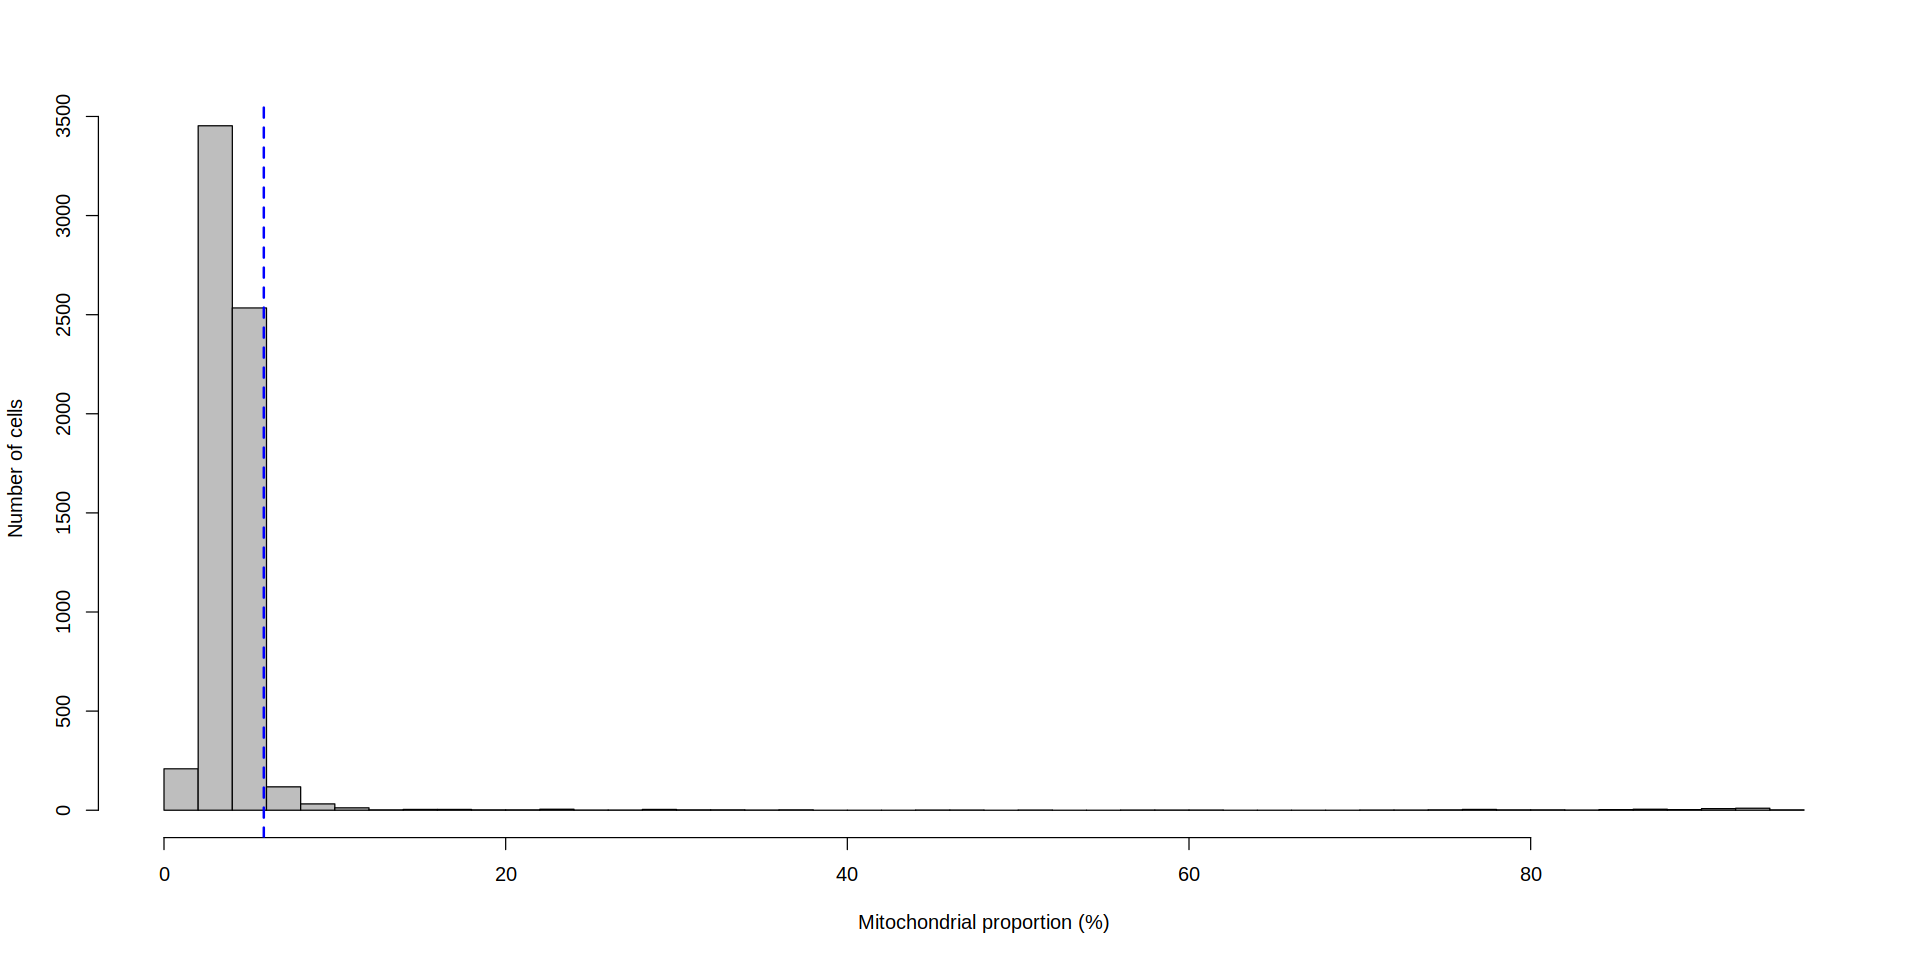

In [24]:
mito.drop <- isOutlier(sce_E10_5$subsets_Mito_percent, nmads = 3)

max.mito <- median(sce_E10_5$subsets_Mito_percent) + 3*mad(sce_E10_5$subsets_Mito_percent)

hist(sce_E10_5$subsets_Mito_percent, xlab = "Mitochondrial proportion (%)",
     ylab = "Number of cells",
     breaks = 40, main = "", col = "grey")

abline(v = max.mito, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [25]:
sce_E10_5_QC <- sce_E10_5[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sce_E10_5_QC))

ByLibrarySize,ByFeature,ByMito,Remaining
<int>,<int>,<int>,<int>
320,386,470,5826


#### 2.1.2. Filtering out low-abundance genes

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for
reliable statsitical inference. Here, low-abundance genes are defined as those with an average count below a
filter threshold of 0.001 (Davie et al., 2018). Removal of these genes mitigates discreteness and reduces the
amount of computational work without major (if any) loss of information.

In [26]:
average.counts <- calculateAverage(sce_E10_5_QC, exprs_values = "counts",
                                   subset_row = NULL)
genes.to.keep <- average.counts >= 0.001
sum(genes.to.keep)

[1] 19399

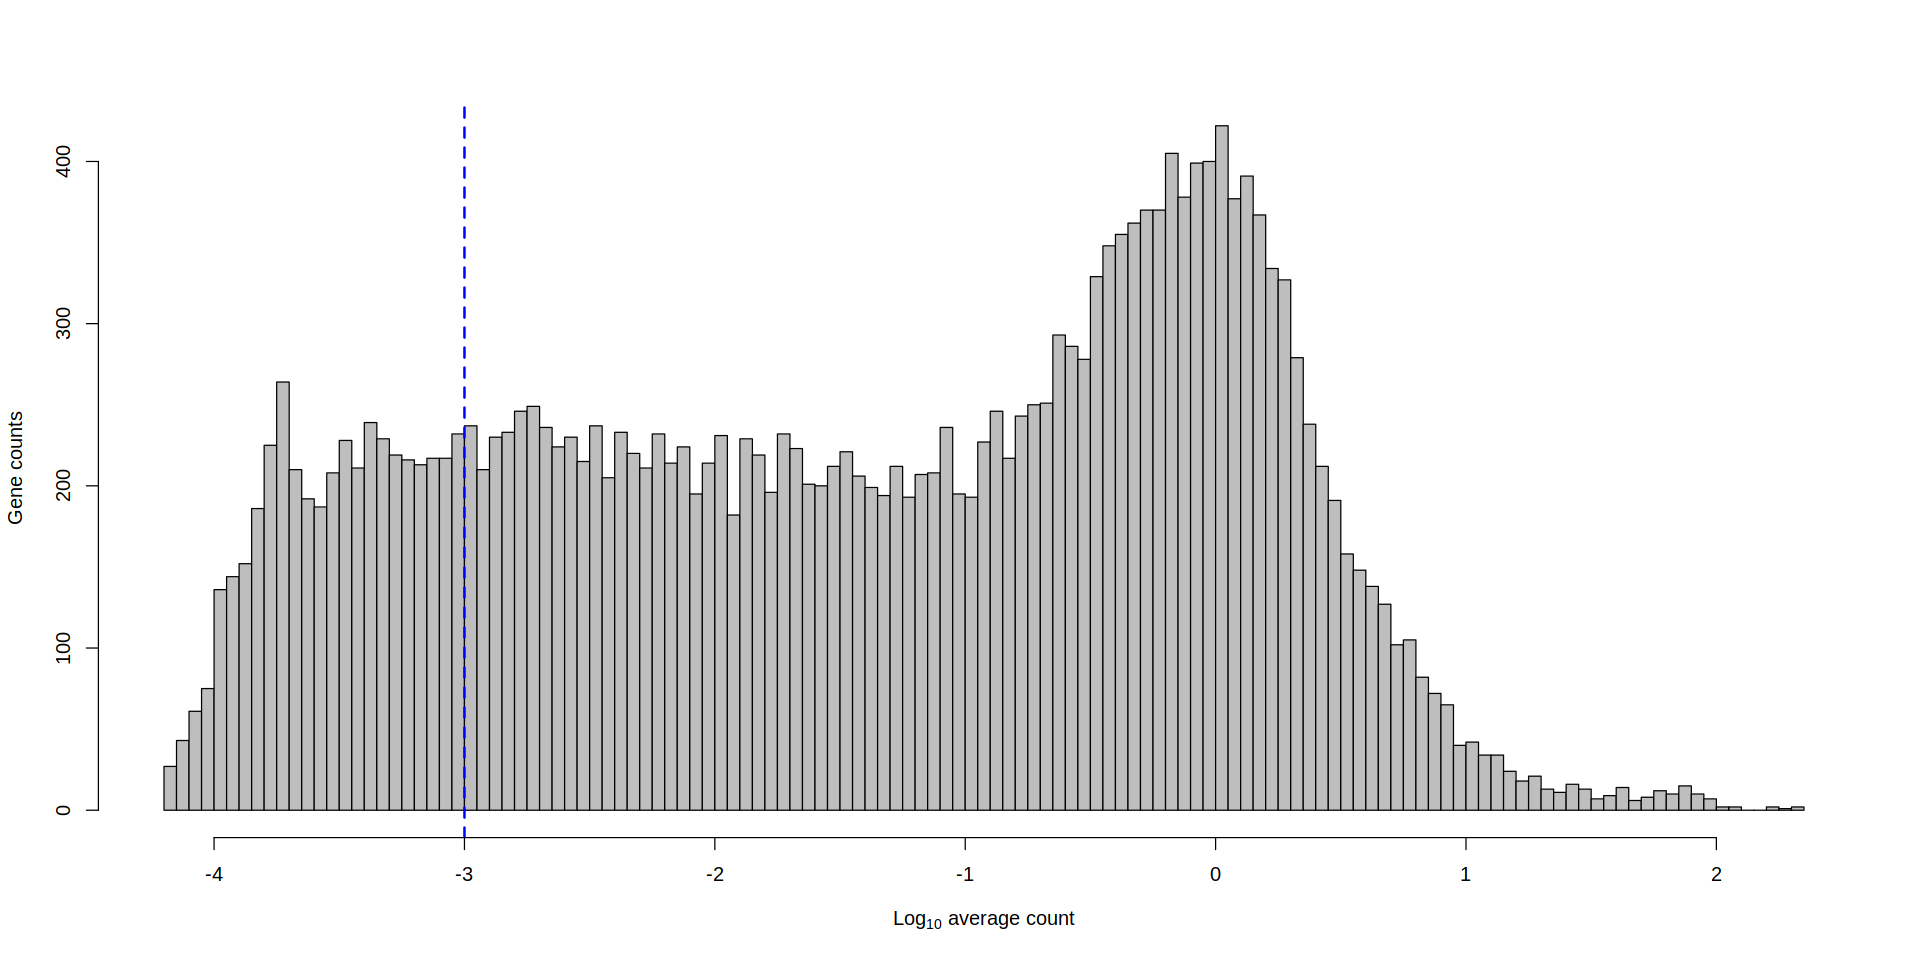

In [27]:
hist(log10(average.counts), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.001), col = "blue", lwd = 2, lty = 2)

rm(average.counts)

Apply the mean-based filter to the data by subsetting the `SingleCellExperiment` object.

In [28]:
sce_E10_5 <- sce_E10_5_QC[genes.to.keep,]

rm(sce_E10_5_QC)

dim(sce_E10_5)

[1] 19399  5826

#### 2.1.3. Duplicate removal

In [29]:
sce_E10_5 <- sce_E10_5[!duplicated(rownames(sce_E10_5)),]
dim(sce_E10_5)

[1] 19399  5826

In [30]:
E10_5 <- as.Seurat(sce_E10_5)

In [32]:
saveRDS(E10_5, file = "./6-kmita/RDS_QC/E10_5.Rds")

### 2.2. E11.5<a id="6"></a>

#### 2.2.1. Converting a Seurat object to SingleCellExperiment 

In [33]:
sce_E11_5 <- as.SingleCellExperiment(E11_5)

#### 2.2.2. Calculating QC metrics

In [34]:
is.mito <- grepl("^mt-", rownames(sce_E11_5))
mito.list <-  grep("^mt-", rownames(sce_E11_5), value = TRUE)

In [35]:
is.spike <- grepl("^gSpikein", rownames(sce_E11_5))
spike.list <- grep("^gSpikein", rownames(sce_E11_5), value = TRUE)

In [36]:
celldata <- perCellQCMetrics(sce_E11_5, subsets = list(Mt = is.mito, ERCC = is.spike))

In [37]:
sce_E11_5 <- addPerCellQC(sce_E11_5, subsets=list(Mito = is.mito, ERCC = is.spike))
colnames(colData(sce_E11_5))

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
 [4] "Sample_Name"           "Instrument"            "Organism"             
 [7] "Developmental_stage"   "source_name"           "STRAIN"               
[10] "Tissue"                "Technology"            "ident"                
[13] "sum"                   "detected"              "subsets_Mito_sum"     
[16] "subsets_Mito_detected" "subsets_Mito_percent"  "subsets_ERCC_sum"     
[19] "subsets_ERCC_detected" "subsets_ERCC_percent"  "total"

Expression of all ERCC spikeins is 0 because they were not used in this study.

##### **2.2.2.1. QC of the cells by feature number and library size**
Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the **total sum of counts across all features, i.e. genes.** Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as **the number of features with non-zero counts for that cell.** Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. **We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median** (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.

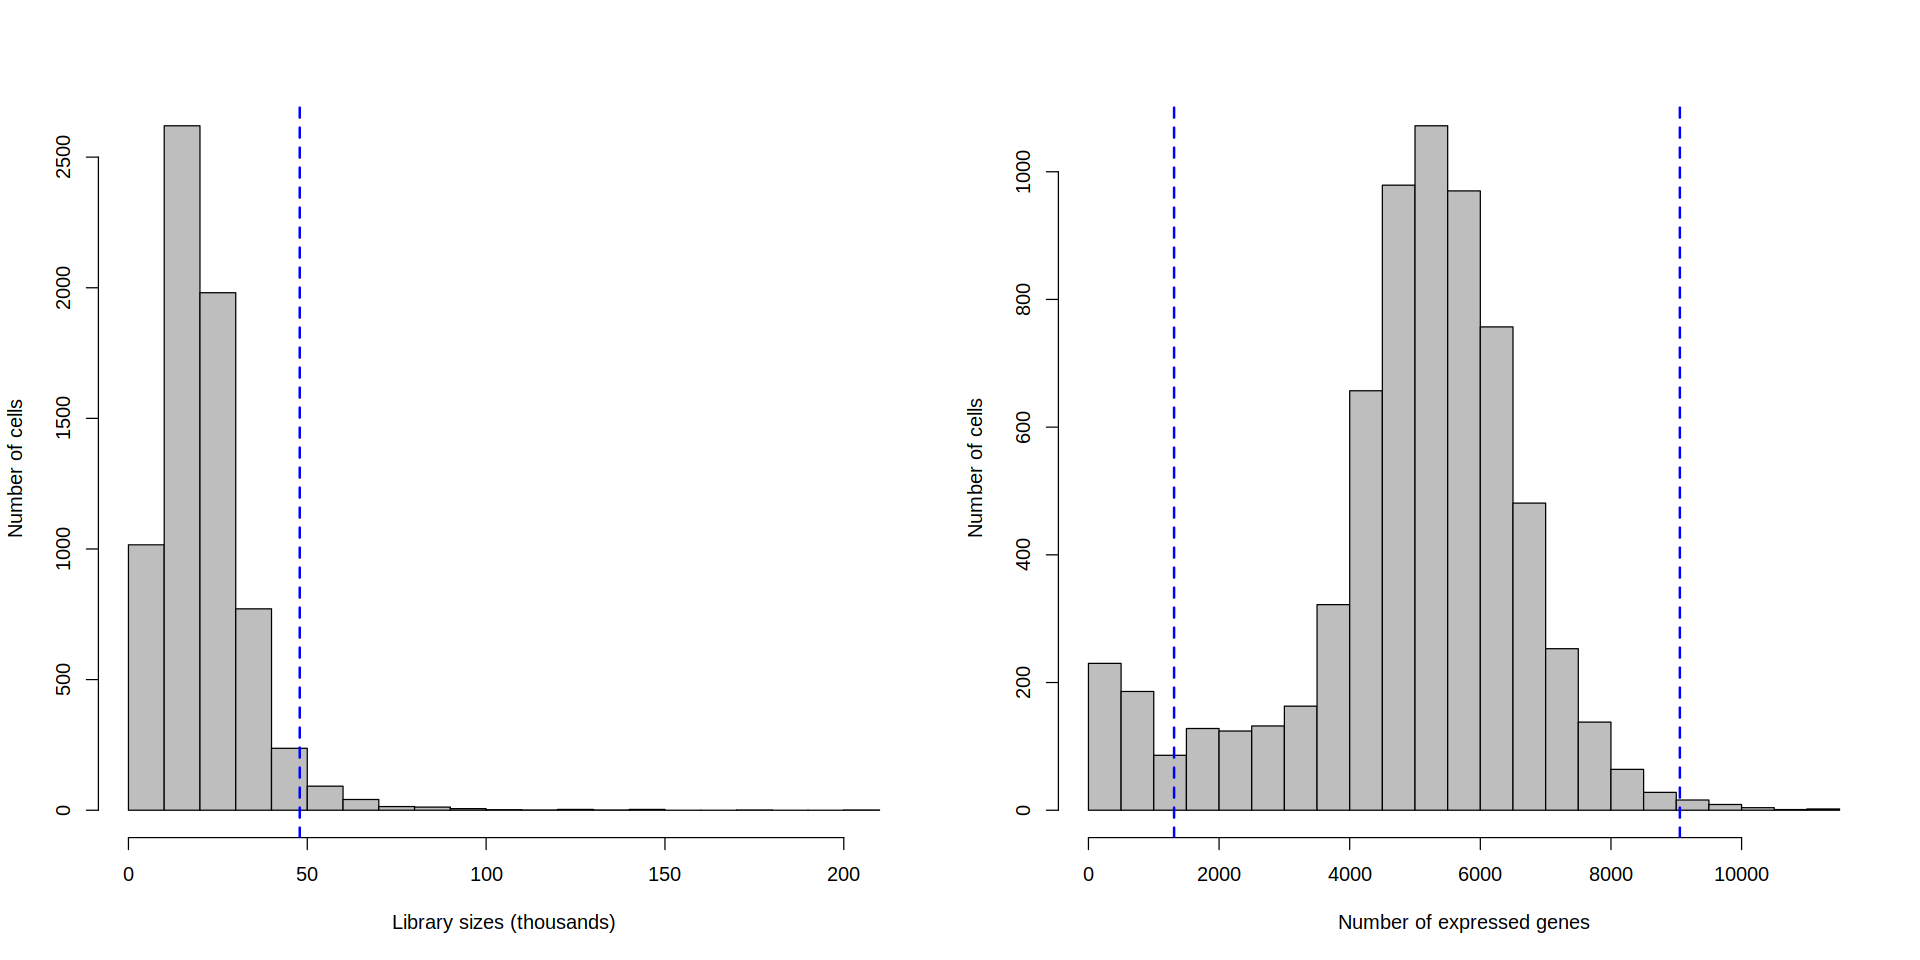

In [38]:
libsize.drop <- isOutlier(sce_E11_5$sum, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sce_E11_5$detected, nmads = 3, type = "both", log = TRUE)

# libsize.drop cutoff values
min.libsize <- (median(sce_E11_5$sum) - 3*mad(sce_E11_5$sum))/1e3
max.libsize <- (median(sce_E11_5$sum) + 3*mad(sce_E11_5$sum))/1e3

# feature.drop cutoff values
min.features <- (median(sce_E11_5$detected) - 3*mad(sce_E11_5$detected))
max.features <- (median(sce_E11_5$detected) + 3*mad(sce_E11_5$detected))

par(mfrow = c(1,2))

hist(sce_E11_5$sum/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.libsize, col = "blue", lwd = 2, lty = 2)
abline(v = max.libsize, col = "blue", lwd = 2, lty = 2)

hist(sce_E11_5$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

##### **2.2.2.2. Proportion of mitochondrial reads**

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

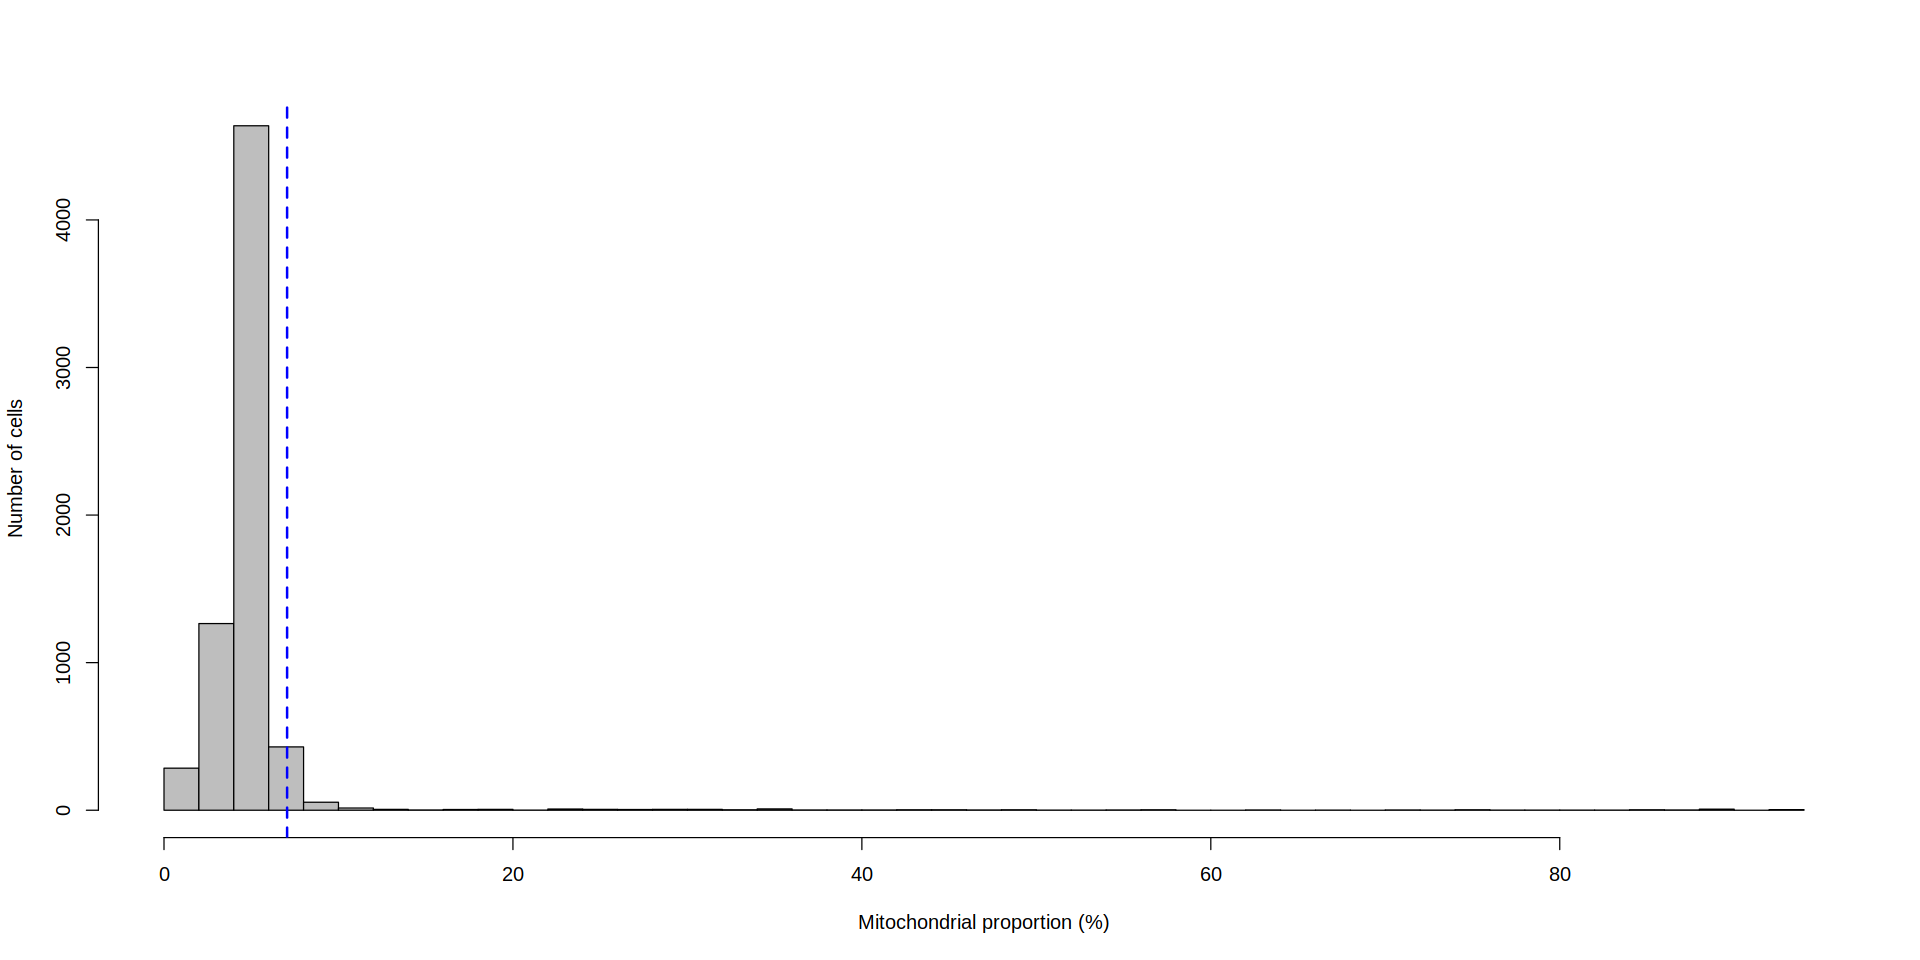

In [39]:
mito.drop <- isOutlier(sce_E11_5$subsets_Mito_percent, nmads = 3)

max.mito <- median(sce_E11_5$subsets_Mito_percent) + 3*mad(sce_E11_5$subsets_Mito_percent)

hist(sce_E11_5$subsets_Mito_percent, xlab = "Mitochondrial proportion (%)",
     ylab = "Number of cells",
     breaks = 40, main = "", col = "grey")

abline(v = max.mito, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [40]:
sce_E11_5_QC <- sce_E11_5[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sce_E11_5_QC))

ByLibrarySize,ByFeature,ByMito,Remaining
<int>,<int>,<int>,<int>
598,753,546,5837


#### 2.2.2. Filtering out low-abundance genes

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for
reliable statsitical inference. Here, low-abundance genes are defined as those with an average count below a
filter threshold of 0.001 (Davie et al., 2018). Removal of these genes mitigates discreteness and reduces the
amount of computational work without major (if any) loss of information.

In [41]:
average.counts_E11.5 <- calculateAverage(sce_E11_5_QC, exprs_values = "counts",
                                   subset_row = NULL)
genes.to.keep_E11.5 <- average.counts_E11.5 >= 0.001
sum(genes.to.keep_E11.5)

[1] 19889

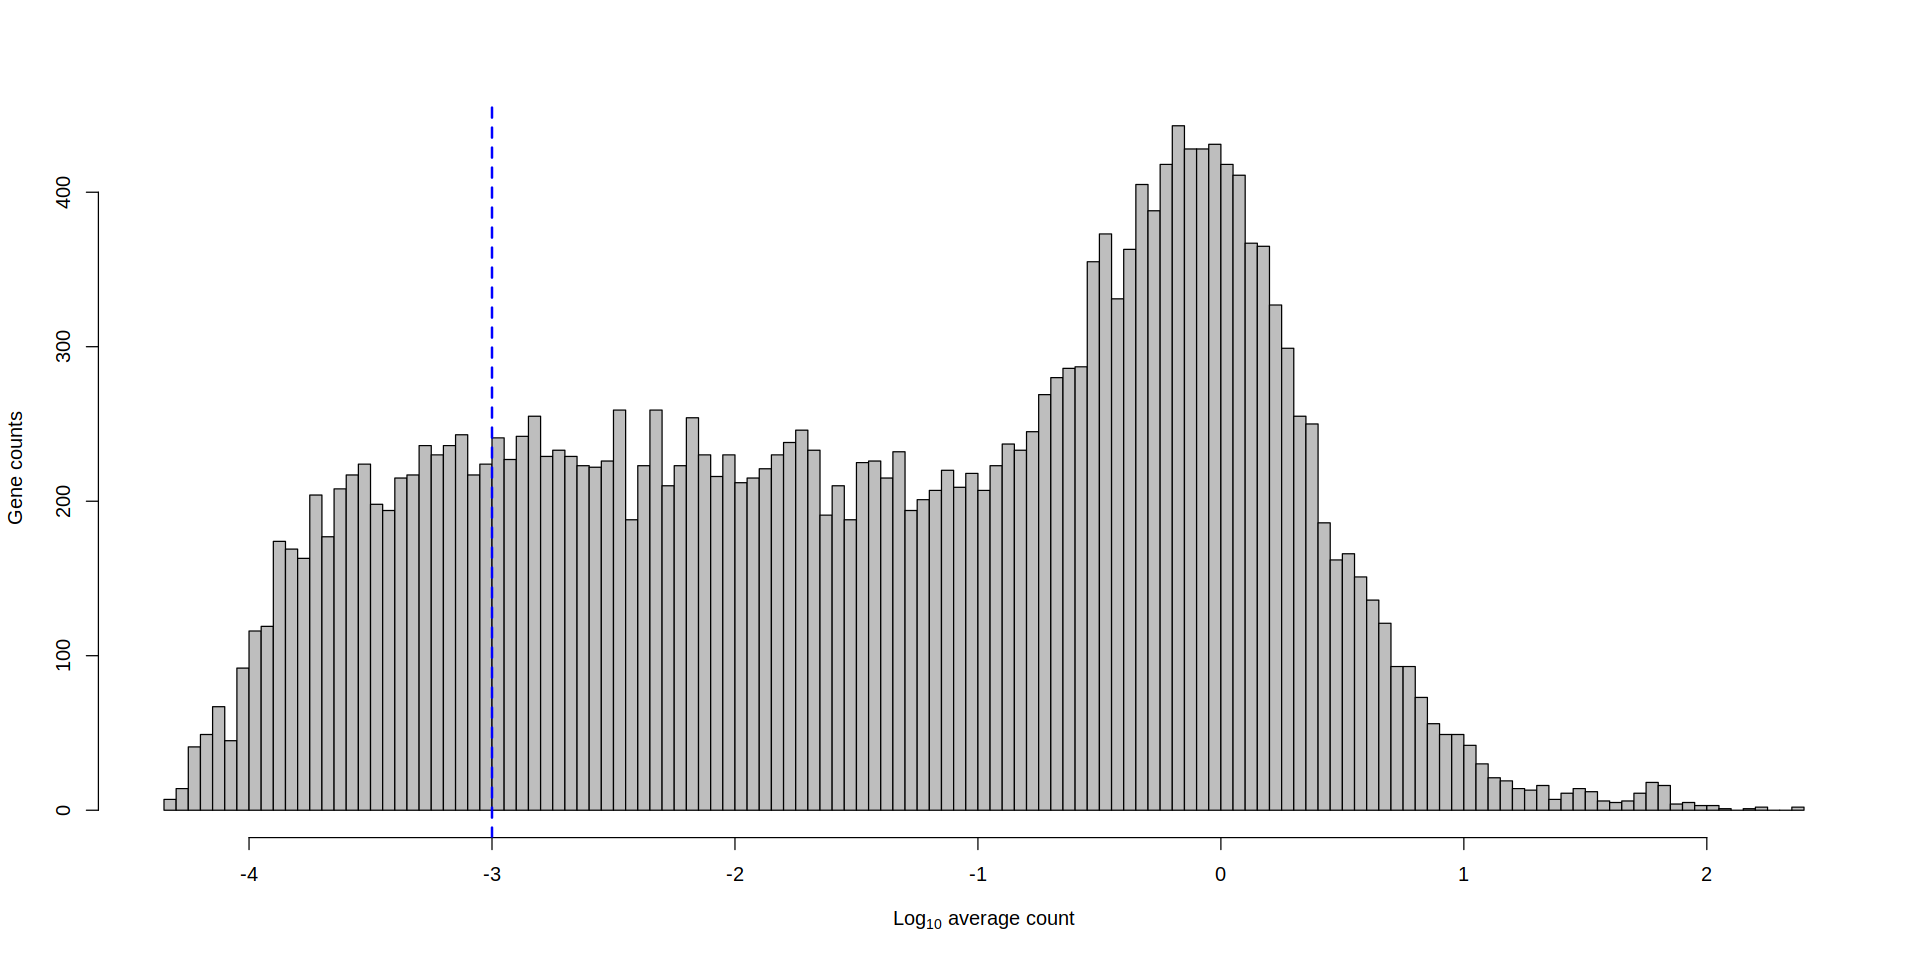

In [42]:
hist(log10(average.counts_E11.5), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.001), col = "blue", lwd = 2, lty = 2)

Apply the mean-based filter to the data by subsetting the `SingleCellExperiment` object.

In [43]:
sce_E11_5 <- sce_E11_5_QC[genes.to.keep_E11.5,]
dim(sce_E11_5)

[1] 19889  5837

#### 2.2.3. Duplication removal

In [44]:
sce_E11_5 <- sce_E11_5[!duplicated(rownames(sce_E11_5)),]
dim(sce_E11_5)

[1] 19889  5837

In [45]:
E11_5 <- as.Seurat(sce_E11_5)

In [46]:
saveRDS(E11_5, file = "./6-kmita/RDS_QC/E11_5.Rds")

### 2.3. E12.5<a id="7"></a>

#### 2.3.1. Converting a Seurat object to SingleCellExperiment 

In [47]:
sce_E12_5 <- as.SingleCellExperiment(E12_5)

#### 2.3.2. Calculating QC metrics

In [48]:
is.mito <- grepl("^mt-", rownames(sce_E12_5))
mito.list <-  grep("^mt-", rownames(sce_E12_5), value = TRUE)

In [49]:
is.spike <- grepl("^gSpikein", rownames(sce_E12_5))
spike.list <- grep("^gSpikein", rownames(sce_E12_5), value = TRUE)

In [50]:
celldata <- perCellQCMetrics(sce_E12_5, subsets = list(Mt = is.mito, ERCC = is.spike))

In [51]:
sce_E12_5 <- addPerCellQC(sce_E12_5, subsets=list(Mito = is.mito, ERCC = is.spike))
colnames(colData(sce_E12_5))

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
 [4] "Sample_Name"           "Instrument"            "Organism"             
 [7] "Developmental_stage"   "source_name"           "STRAIN"               
[10] "Tissue"                "Technology"            "ident"                
[13] "sum"                   "detected"              "subsets_Mito_sum"     
[16] "subsets_Mito_detected" "subsets_Mito_percent"  "subsets_ERCC_sum"     
[19] "subsets_ERCC_detected" "subsets_ERCC_percent"  "total"

Expression of all ERCC spikeins is 0 because they were not used in this study.

##### **2.3.2.1. QC of the cells by feature number and library size**
Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the **total sum of counts across all features, i.e. genes.** Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as **the number of features with non-zero counts for that cell.** Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. **We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median** (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.

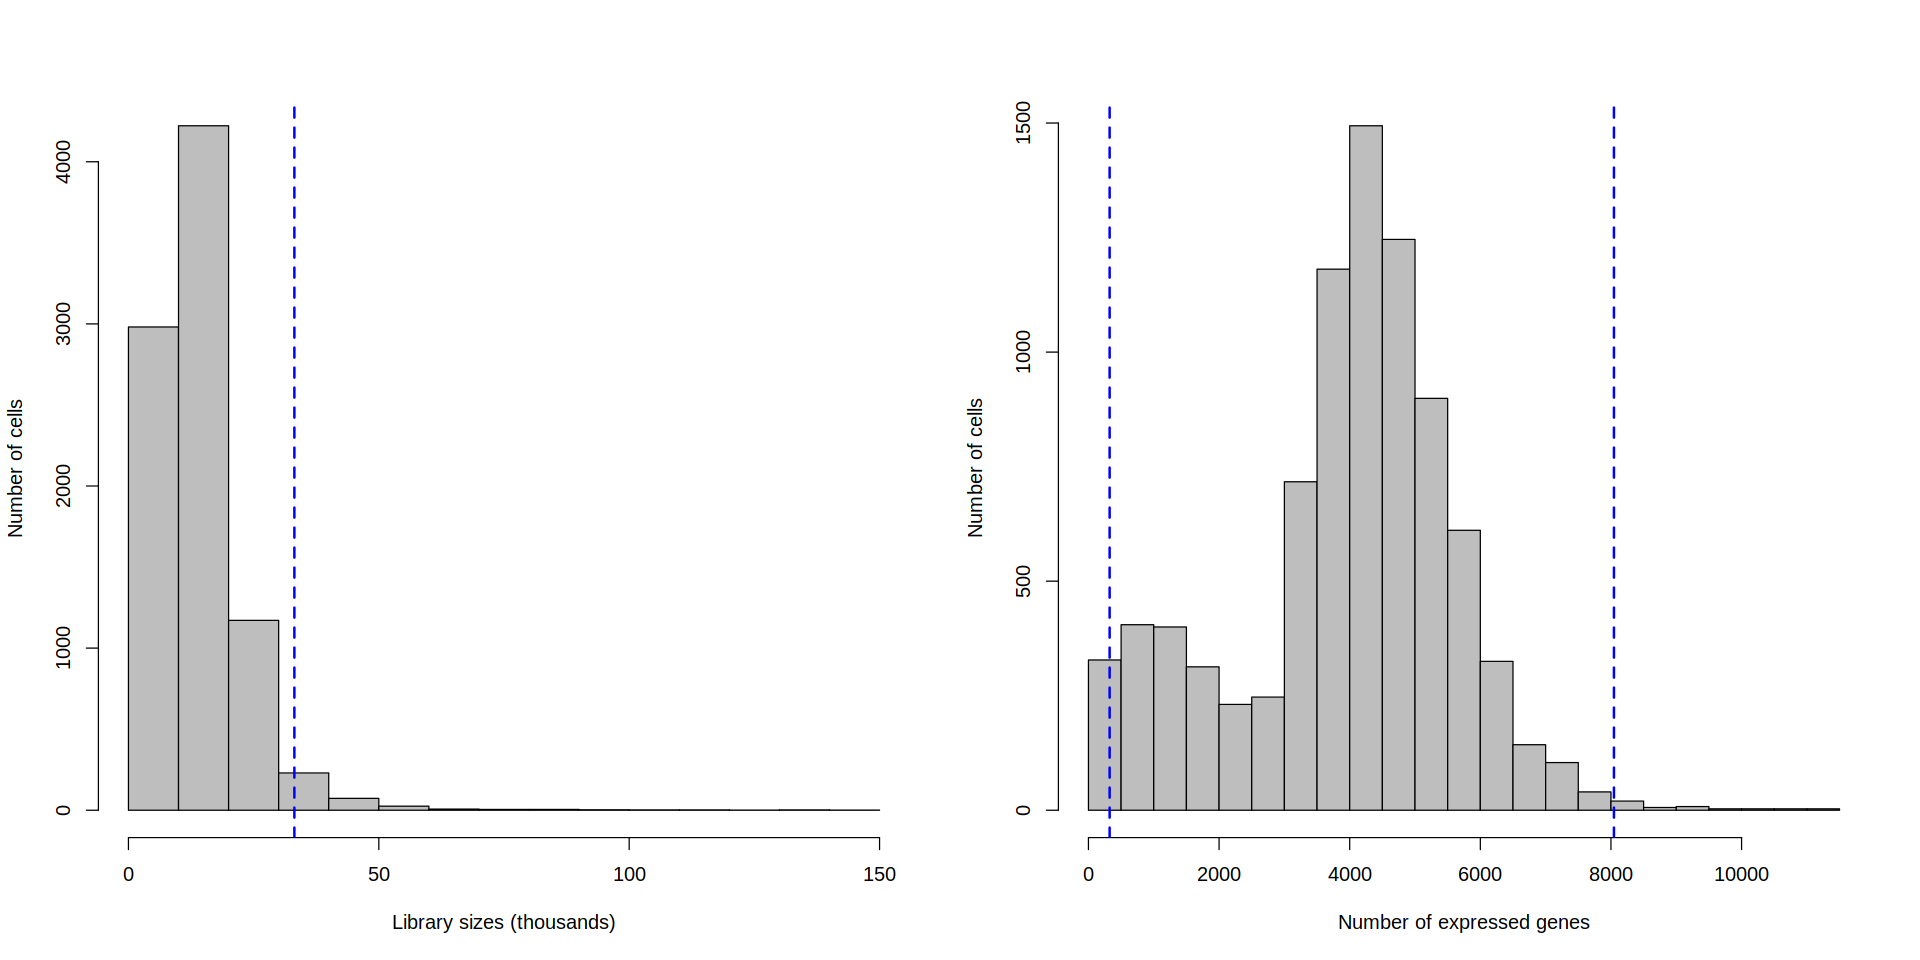

In [52]:
libsize.drop <- isOutlier(sce_E12_5$sum, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sce_E12_5$detected, nmads = 3, type = "both", log = TRUE)

# libsize.drop cutoff values
min.libsize <- (median(sce_E12_5$sum) - 3*mad(sce_E12_5$sum))/1e3
max.libsize <- (median(sce_E12_5$sum) + 3*mad(sce_E12_5$sum))/1e3

# feature.drop cutoff values
min.features <- (median(sce_E12_5$detected) - 3*mad(sce_E12_5$detected))
max.features <- (median(sce_E12_5$detected) + 3*mad(sce_E12_5$detected))

par(mfrow = c(1,2))

hist(sce_E12_5$sum/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.libsize, col = "blue", lwd = 2, lty = 2)
abline(v = max.libsize, col = "blue", lwd = 2, lty = 2)

hist(sce_E12_5$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

##### **2.3.2.2. Proportion of mitochondrial reads**

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

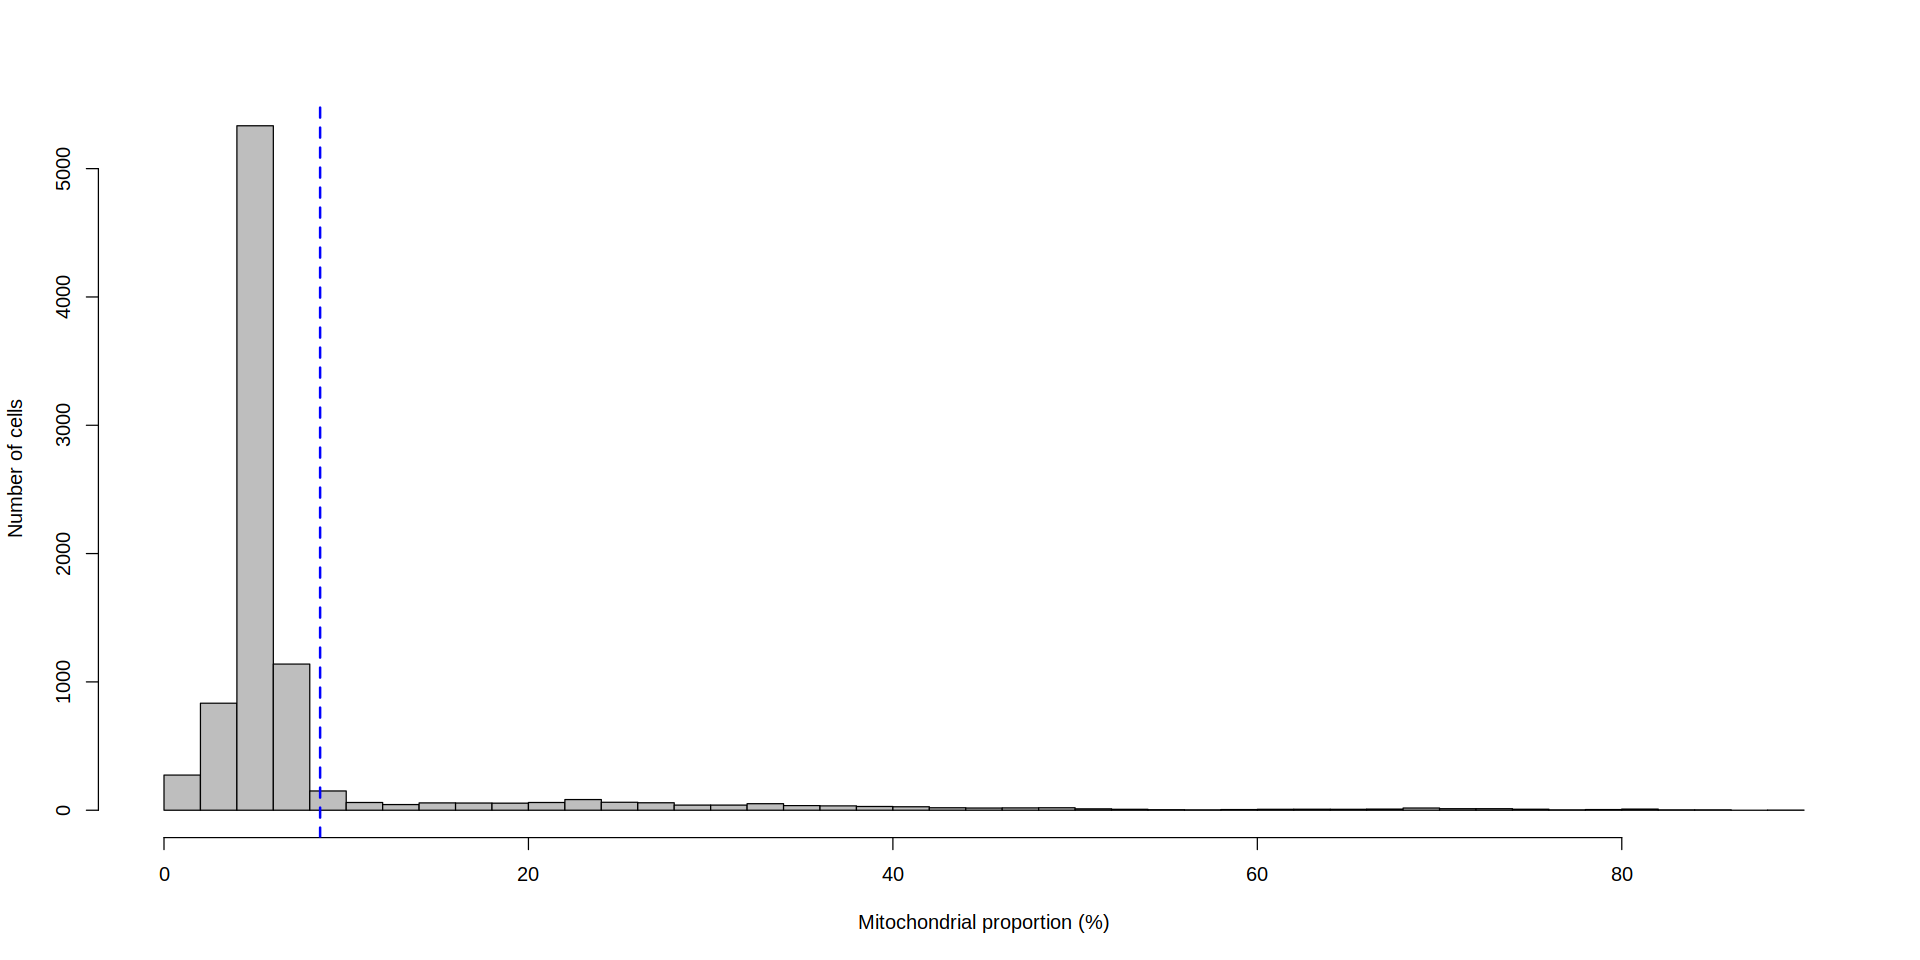

In [53]:
mito.drop <- isOutlier(sce_E12_5$subsets_Mito_percent, nmads = 3)

max.mito <- median(sce_E12_5$subsets_Mito_percent) + 3*mad(sce_E12_5$subsets_Mito_percent)

hist(sce_E12_5$subsets_Mito_percent, xlab = "Mitochondrial proportion (%)",
     ylab = "Number of cells",
     breaks = 40, main = "", col = "grey")

abline(v = max.mito, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [54]:
sce_E12_5_QC <- sce_E12_5[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sce_E12_5_QC))

ByLibrarySize,ByFeature,ByMito,Remaining
<int>,<int>,<int>,<int>
891,1270,1348,6986


#### 2.3.3. Filtering out low-abundance genes

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for
reliable statsitical inference. Here, low-abundance genes are defined as those with an average count below a
filter threshold of 0.001 (Davie et al., 2018). Removal of these genes mitigates discreteness and reduces the
amount of computational work without major (if any) loss of information.

In [55]:
average.counts_E12.5 <- calculateAverage(sce_E12_5_QC, exprs_values = "counts",
                                   subset_row = NULL)
genes.to.keep_E12.5 <- average.counts_E12.5 >= 0.001
sum(genes.to.keep_E12.5)

[1] 19334

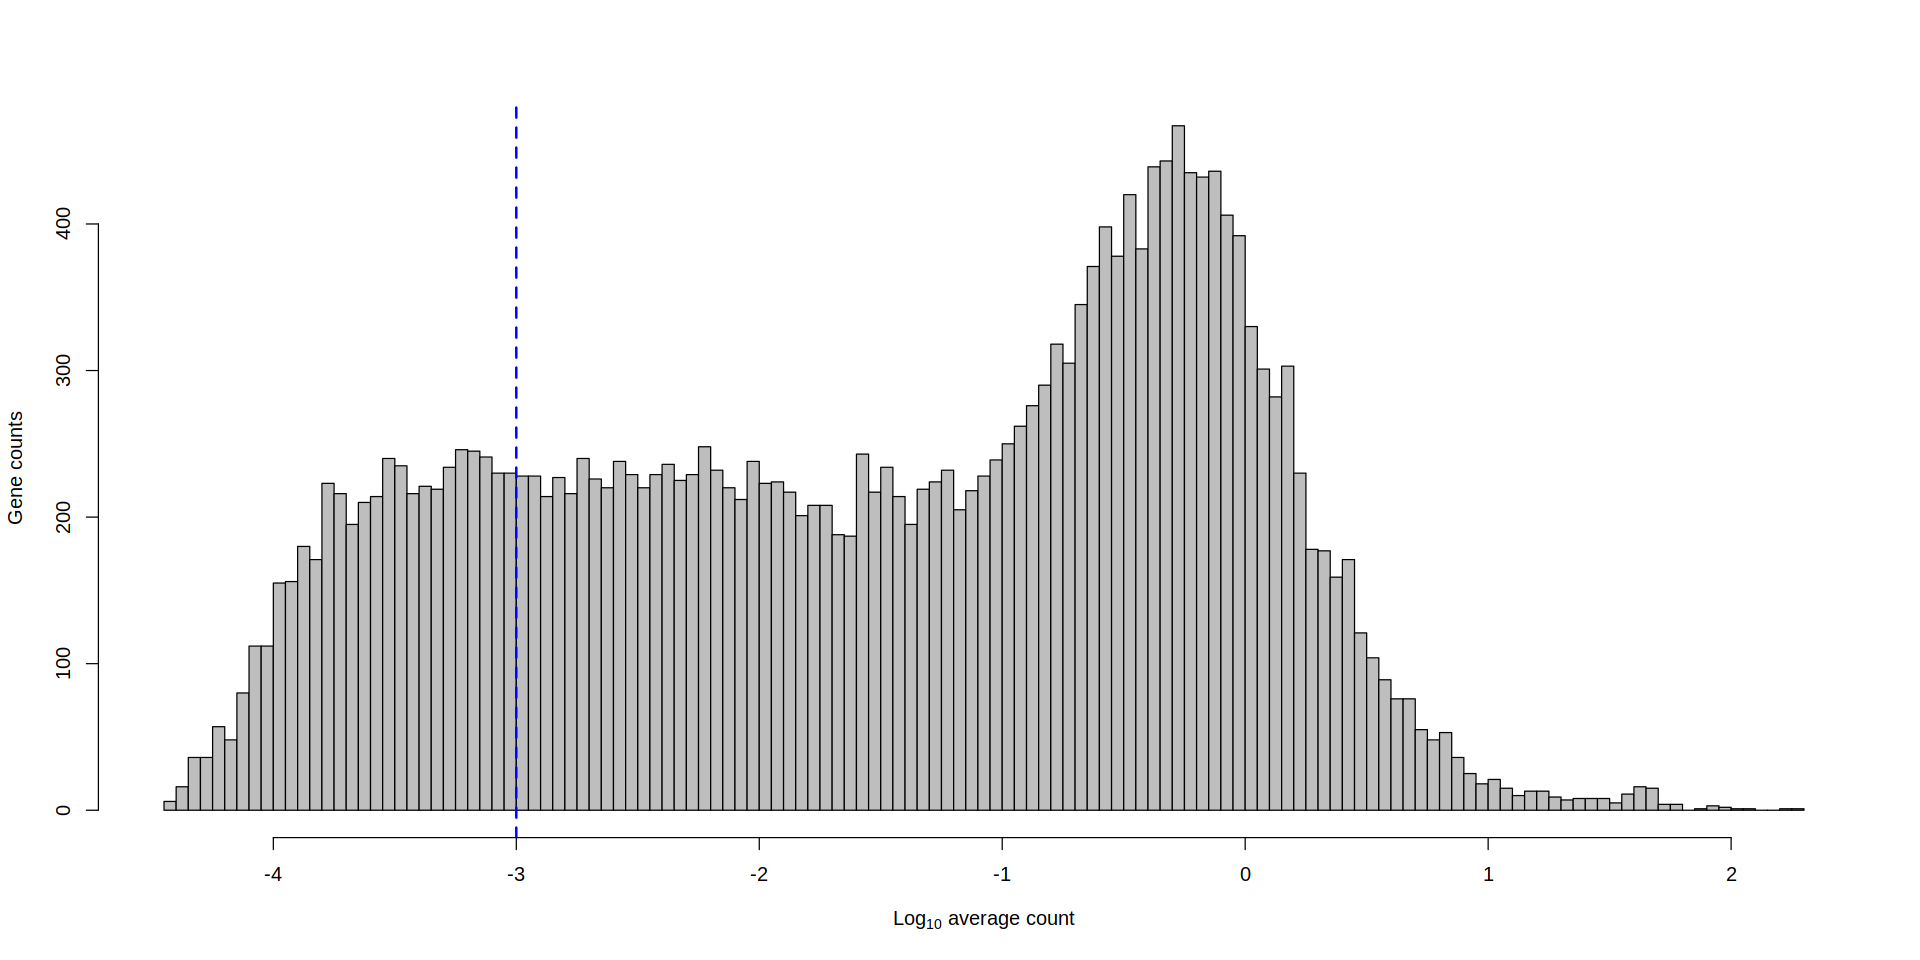

In [56]:
hist(log10(average.counts_E12.5), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.001), col = "blue", lwd = 2, lty = 2)

Apply the mean-based filter to the data by subsetting the `SingleCellExperiment` object.

In [57]:
sce_E12_5 <- sce_E12_5_QC[genes.to.keep_E12.5,]
dim(sce_E12_5)

[1] 19334  6986

#### 2.3.4. Duplicate removal

In [58]:
sce_E12_5 <- sce_E12_5[!duplicated(rownames(sce_E12_5)),]
dim(sce_E12_5)

[1] 19334  6986

In [59]:
E12_5 <- as.Seurat(sce_E12_5)

In [60]:
saveRDS(E12_5, file = "./6-kmita/RDS_QC/E12_5.Rds")